# Movie Recommendation System

#### The objective of this Project is to build an app which will allow users to search for movies and will also be provided recommendations.


#### In this project we will be using a hybrid  recommender sytem consisting of item based collaborative filtering to find the similar movies to a user whose data is already present and content based recommender system will be used to solve the cold start problem which will help to recommend a movie to a user whose data is not present.


#### Libraries that will be used in this project are as follows: 


#### Pandas,Numpy,Datetime,Sklearn,Matplotlib,scipy,seaborn


# Meta Data

## Summary

#### This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.



#### Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.



#### The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.



## Ratings Data File Structure (ratings.csv)

#### All ratings are contained in the file `ratings.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format: userId,movieId,rating,timestamp


#### The lines within this file are ordered first by userId, then, within user, by movieId.


#### Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).


#### Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.



## Tags Data File Structure (tags.csv)

#### All tags are contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format: userId,movieId,tag,timestamp

#### The lines within this file are ordered first by userId, then, within user, by movieId.

#### Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

#### Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.




## Movies Data File Structure (movies.csv)

#### Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format:movieId,title,genres

#### Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

#### Genres are a pipe-separated list, and are selected from the following:

#### * Action,* Adventure* Animation* Children's* Comedy* Crime* Documentary* Drama* Fantasy* Film-Noir* Horror* Musical* Mystery* Romance* Sci-Fi* Thriller* War* Western* (no genres listed)



## Links Data File Structure (links.csv)


#### Identifiers that can be used to link to other sources of movie data are contained in the file `links.csv`. Each line of this file after the header row represents one movie, and has the following format: movieId,imdbId,tmdbId

#### movieId is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

#### imdbId is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

#### tmdbId is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>.

In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

# Convert all related csv files to panda dataframe

In [66]:
ratings_df=pd.read_csv("ratings.csv")
user_info=ratings_df[['userId']]
user_info=user_info.drop_duplicates()
user_info.head(10)

,userId
0,1
232,2
261,3
300,4
516,5
560,6
874,7
1026,8
1073,9
1119,10


In [67]:
movies_df=pd.read_csv("movies.csv")
movies_df.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [68]:
tags_df=pd.read_csv("tags.csv")
tags_df=tags_df[['movieId','tag']]
tags=tags_df.groupby('movieId').agg(lambda x: x.tolist())
tags.head(10)

,tag
movieId,
1,"[pixar, pixar, fun]"
2,"[fantasy, magic board game, Robin Williams, game]"
3,"[moldy, old]"
5,"[pregnancy, remake]"
7,[remake]
11,"[politics, president]"
14,"[politics, president]"
16,[Mafia]
17,[Jane Austen]


In [69]:
links_df=pd.read_csv("links.csv")
links_df.head(10)
poster_df=pd.merge(movies_df,links_df,on='movieId',how='left')
poster_df.head(10)

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0
5,6,Heat (1995),Action|Crime|Thriller,113277,949.0
6,7,Sabrina (1995),Comedy|Romance,114319,11860.0
7,8,Tom and Huck (1995),Adventure|Children,112302,45325.0
8,9,Sudden Death (1995),Action,114576,9091.0
9,10,GoldenEye (1995),Action|Adventure|Thriller,113189,710.0


# Merging Datasets

In [70]:
ratingsm_df=pd.merge(ratings_df,movies_df,on='movieId',how='left')
ratingsm_df=ratingsm_df.merge(tags_df,on='movieId',how='left')
# print(ratingsm_df.dtypes)
ratingsm_df.head(10)

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
5,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN
6,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,mystery
7,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,twist ending
8,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,serial killer
9,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,mindfuck


# One-Hot Encoding Genres

In [71]:

g = set()
for i in ratingsm_df['genres']:
    temp = i.split("|")
    g.update(temp)
print(g)


{'Thriller', 'Sci-Fi', 'Comedy', 'Drama', 'Fantasy', 'Adventure', 'Mystery', 'Animation', 'Romance', 'Film-Noir', 'Documentary', 'Crime', 'Children', '(no genres listed)', 'Western', 'IMAX', 'Musical', 'War', 'Horror', 'Action'}


In [72]:
l1=[]
for i in g:
    l1.append(i)
    ratingsm_df[i] = ratingsm_df['genres'].str.contains(i)*1

In [73]:
ratingsm_df.isnull().any()

userId                False
movieId               False
rating                False
timestamp             False
title                 False
genres                False
tag                    True
Thriller              False
Sci-Fi                False
Comedy                False
Drama                 False
Fantasy               False
Adventure             False
Mystery               False
Animation             False
Romance               False
Film-Noir             False
Documentary           False
Crime                 False
Children              False
(no genres listed)    False
Western               False
IMAX                  False
Musical               False
War                   False
Horror                False
Action                False
dtype: bool

In [74]:
 '''Timestamp converted to datetime format'''
ratingsm_df['timestamp'] = pd.to_datetime(ratingsm_df['timestamp'], 
                                  unit='s')  
ratingsm_df.head(5)

ratingsm_df.drop(columns='genres',axis=1)

,userId,movieId,rating,timestamp,title,tag,Thriller,Sci-Fi,Comedy,Drama,...,Documentary,Crime,Children,(no genres listed),Western,IMAX,Musical,War,Horror,Action
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),pixar,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),pixar,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),fun,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),moldy,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),old,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285757,610,168252,5.0,2017-05-03 21:19:12,Logan (2017),emotional,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
285758,610,168252,5.0,2017-05-03 21:19:12,Logan (2017),gritty,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
285759,610,168252,5.0,2017-05-03 21:19:12,Logan (2017),heartbreaking,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
285760,610,168252,5.0,2017-05-03 21:19:12,Logan (2017),predictible plot,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [75]:
ratings2 = pd.merge(ratings_df, movies_df, how='inner', on='movieId')

# Dealing with Missing values

In [76]:
df = ratings2.pivot_table(index='title',columns='userId',values='rating').fillna(0)
df

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0
xXx (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,2.0
xXx: State of the Union (2005),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5


In [77]:
df.describe()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
count,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,...,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000,9719.000000
mean,0.104229,0.011781,0.009775,0.079020,0.016463,0.112872,0.050520,0.017286,0.015434,0.047227,...,0.045992,0.047124,0.340364,0.035806,0.073001,0.419590,0.072847,0.267980,0.012450,0.494135
std,0.677864,0.219661,0.202010,0.559425,0.252863,0.636347,0.433733,0.256846,0.239985,0.415203,...,0.451204,0.413352,1.098750,0.359154,0.494199,1.191134,0.537005,0.931476,0.203259,1.295013
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000


# Normalization

In [78]:
'''Normalization of values is done to avoid noise due to different type of behaviour of people while rating 
a movie... i.e someone might be too lenient while the other may be too harsh'''
def normalize(row):
    n_row=(row-row.mean())/(row.max()-row.min())
    return n_row
df2=df.apply(normalize)
df2

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),-0.020846,-0.002356,-0.001955,-0.015804,-0.003293,-0.022574,-0.010104,-0.003457,-0.003087,-0.009445,...,-0.009198,-0.009425,-0.068073,-0.007161,-0.0146,-0.083918,-0.014569,-0.053596,-0.003112,0.701173
'Hellboy': The Seeds of Creation (2004),-0.020846,-0.002356,-0.001955,-0.015804,-0.003293,-0.022574,-0.010104,-0.003457,-0.003087,-0.009445,...,-0.009198,-0.009425,-0.068073,-0.007161,-0.0146,-0.083918,-0.014569,-0.053596,-0.003112,-0.098827
'Round Midnight (1986),-0.020846,-0.002356,-0.001955,-0.015804,-0.003293,-0.022574,-0.010104,-0.003457,-0.003087,-0.009445,...,-0.009198,-0.009425,-0.068073,-0.007161,-0.0146,-0.083918,-0.014569,-0.053596,-0.003112,-0.098827
'Salem's Lot (2004),-0.020846,-0.002356,-0.001955,-0.015804,-0.003293,-0.022574,-0.010104,-0.003457,-0.003087,-0.009445,...,-0.009198,-0.009425,-0.068073,-0.007161,-0.0146,-0.083918,-0.014569,-0.053596,-0.003112,-0.098827
'Til There Was You (1997),-0.020846,-0.002356,-0.001955,-0.015804,-0.003293,-0.022574,-0.010104,-0.003457,-0.003087,-0.009445,...,-0.009198,-0.009425,-0.068073,-0.007161,-0.0146,-0.083918,-0.014569,-0.053596,-0.003112,-0.098827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),-0.020846,-0.002356,-0.001955,-0.015804,-0.003293,-0.022574,-0.010104,-0.003457,-0.003087,-0.009445,...,-0.009198,-0.009425,0.931927,-0.007161,-0.0146,-0.083918,-0.014569,0.846404,-0.003112,-0.098827
xXx (2002),-0.020846,-0.002356,-0.001955,-0.015804,-0.003293,-0.022574,-0.010104,-0.003457,0.196913,-0.009445,...,-0.009198,-0.009425,-0.068073,-0.007161,-0.0146,-0.083918,-0.014569,0.646404,-0.003112,0.301173
xXx: State of the Union (2005),-0.020846,-0.002356,-0.001955,-0.015804,-0.003293,-0.022574,-0.010104,-0.003457,-0.003087,-0.009445,...,-0.009198,-0.009425,-0.068073,-0.007161,-0.0146,-0.083918,-0.014569,-0.053596,-0.003112,0.201173


# Visualization

Thriller    				130834
Sci-Fi    				60471
Comedy    				119180
Drama    				167783
Fantasy    				22247
Adventure    				60077
Mystery    				27395
Animation    				13866
Romance    				33656
Film-Noir    				1064
Documentary    				1488
Crime    				110712
Children    				16214
(no genres listed)    				49
Western    				3526
IMAX    				14535
Musical    				6314
War    				13802
Horror    				14964
Action    				86976


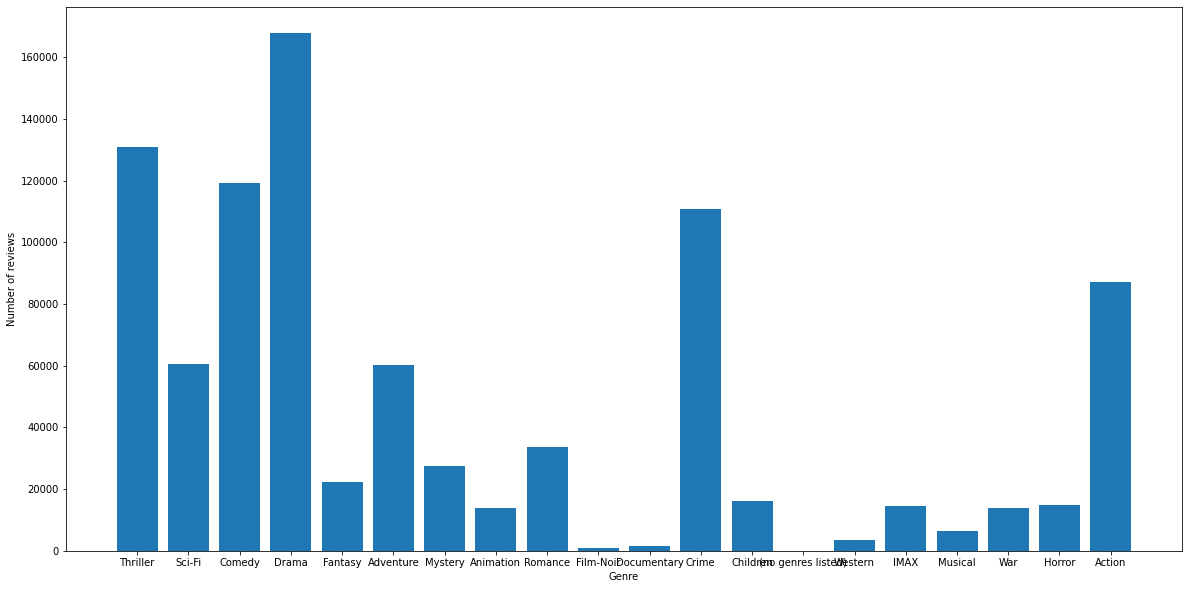

'Here we can see that maximum number of ratings is given Drama genre '

In [79]:
ratingsm_df1=ratingsm_df[l1]
x={}
for i in ratingsm_df1.columns[:]:
    x[i]=ratingsm_df[i].value_counts()[1]
    print("{}    \t\t\t\t{}".format(i,x[i]))

fig = plt.figure() 

# Figure size

fig.set_size_inches(20,10)
plt.bar(height=x.values(),x=x.keys())
plt.xlabel('Genre')
plt.ylabel('Number of reviews')
plt.show()
'''Here we can see that maximum number of ratings is given Drama genre '''

'With this visualisation we can analyze that people tend to rate only those movies which they like as \nwe can see from the visualisation that as the rating increases the number of reviews also increases'

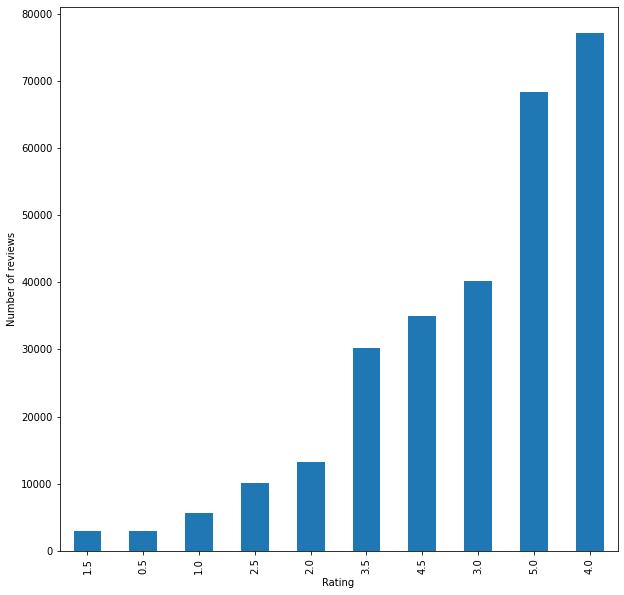

In [80]:
y={}
# print(ratingsm_df.rating.value_counts())
fig = plt.figure() 

# Figure size

fig.set_size_inches(10,10)

ratingsm_df.rating.value_counts().sort_values().plot(kind = 'bar')

plt.xlabel('Rating')
plt.ylabel('Number of reviews')


'''With this visualisation we can analyze that people tend to rate only those movies which they like as 
we can see from the visualisation that as the rating increases the number of reviews also increases'''

In [81]:
# ratings_df["movieId"].value_counts()

# fig = plt.figure() 
# fig.set_size_inches(200,200)

# ratings_df["movieId"].value_counts().plot(kind = 'bar')
# plt.xlabel('MovieId')
# plt.ylabel('# of Ratings')
# plt.show()

'''Here we can see some popular items are there which are having a lot of interactions whereas most of the movies are
in the long tail not having a lot of interactions.'''

'''So it will be easy for recommender system to predict the movies in the head whereas it will be difficult 
for it to predict those in the long tail'''

'So it will be easy for recommender system to predict the movies in the head whereas it will be difficult \nfor it to predict those in the long tail'

# Prediction Models

# Content Based Recommender System Model

In [82]:
'''Content based Recommender System Model will help to deal with cold start problem when we dont have any information 
about the new user'''

rtm=pd.merge(movies_df,tags,on='movieId',how='left')

cbd=rtm[["movieId","title","genres","tag"]]

cbd['genres']=cbd['genres'].apply(lambda x:x.split("|"))

isna = cbd['tag'].isna()
cbd.loc[isna, 'tag'] = pd.Series([[]] * isna.sum()).values

cbd['tags']=cbd['genres'] +  cbd['tag']
cbd=cbd[['movieId','title','tags']]

cbd['tags']=cbd['tags'].apply(lambda x:" ".join(x))

cbd.head(10)
cv=CountVectorizer(max_features=5000,stop_words='english')

vector=cv.fit_transform(cbd['tags']).toarray()

similarity=cosine_similarity(vector)

print(similarity)

[[1.         0.3380617  0.15811388 ... 0.         0.2236068  0.31622777]
 [0.3380617  1.         0.         ... 0.         0.         0.        ]
 [0.15811388 0.         1.         ... 0.         0.         0.5       ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.2236068  0.         0.         ... 0.         1.         0.        ]
 [0.31622777 0.         0.5        ... 0.         0.         1.        ]]


In [83]:
def recommend_cf(movie):
    movie_index=cbd[cbd['title']== movie].index[0]
    print(cbd[cbd['title']== movie])
    distances=similarity[movie_index]
    movies_list=sorted(list(enumerate(distances)),reverse=True,key=lambda x: x[1])[1:15]
    
    recommended_list=[]
    for i in movies_list:
        recommended_list.append(cbd.iloc[i[0]].title)
    return recommended_list    
        

In [84]:
rc=recommend_cf('Antz (1998)')

      movieId        title                                         tags
1706     2294  Antz (1998)  Adventure Animation Children Comedy Fantasy


# Item Based Collaborative Filtering

In [85]:
'''Item based collaborative filtering will be used for the user whose data is already present with us'''
df1 = df.copy()
def recommend_movies(user, num_recommended_movies):

#     print('The list of the Movies {} Has Watched \n'.format(user))

    for m in df[df[user] > 0][user].index.tolist():
#         print(m)
        recommended_movies = []

    for m in df[df[user] == 0].index.tolist():

        index_df = df.index.tolist().index(m)
        predicted_rating = df1.iloc[index_df, df1.columns.tolist().index(user)]
        recommended_movies.append((m, predicted_rating))

        sorted_rm = sorted(recommended_movies, key=lambda x:x[1], reverse=True)

    print('The list of the Recommended Movies \n')
#     rank = 1
    recommended_movie_list=[]
    recommended_movie_ids=[]
    for recommended_movie in sorted_rm[:num_recommended_movies]:
        recommended_movie_list.append(recommended_movie[0])
        recommended_movie_ids.append((str(movies_df[movies_df['title']==recommended_movie[0]].movieId).split(" ")[4]).split("\n")[0])
#         print('{}: {} - predicted rating:{}'.format(rank, recommended_movie[0], recommended_movie[1]))
#         rank = rank + 1
    return recommended_movie_list,recommended_movie_ids

In [86]:
def movie_recommender(user, num_neighbors, num_recommendation):
    lis=[]
    number_neighbors = num_neighbors
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(df2.values)
    distances, indices = knn.kneighbors(df2.values, n_neighbors=number_neighbors)

    user_index = df.columns.tolist().index(user)

    for m,t in list(enumerate(df.index)):
        if df.iloc[m, user_index] == 0:
            sim_movies = indices[m].tolist()
            movie_distances = distances[m].tolist()

            if m in sim_movies:
                id_movie = sim_movies.index(m)
                sim_movies.remove(m)
                movie_distances.pop(id_movie) 

            else:
                sim_movies = sim_movies[:num_neighbors-1]
                movie_distances = movie_distances[:num_neighbors-1]

            movie_similarity = [1-x for x in movie_distances]
            movie_similarity_copy = movie_similarity.copy()
            nominator = 0

            for s in range(0, len(movie_similarity)):
                if df.iloc[sim_movies[s], user_index] == 0:
                    if len(movie_similarity_copy) == (number_neighbors - 1):
                        movie_similarity_copy.pop(s)

                    else:
                        movie_similarity_copy.pop(s-(len(movie_similarity)-len(movie_similarity_copy)))

                else:
                    nominator = nominator + movie_similarity[s]*df.iloc[sim_movies[s],user_index]

            if len(movie_similarity_copy) > 0:
                
                if sum(movie_similarity_copy) > 0:
                    predicted_r = nominator/sum(movie_similarity_copy)

                else:
                    predicted_r = 0

            else:
                predicted_r = 0

            df1.iloc[m,user_index] = predicted_r
    lis,rmi=recommend_movies(user,num_recommendation)
    return lis,rmi

In [87]:
lis2=[]
rmi=[]
lis2,rmi=movie_recommender(15, 16, 16)
for i in lis2:
    print(i)

The list of the Recommended Movies 

'71 (2014)
'Hellboy': The Seeds of Creation (2004)
'Round Midnight (1986)
'Salem's Lot (2004)
'Til There Was You (1997)
'Tis the Season for Love (2015)
'burbs, The (1989)
'night Mother (1986)
*batteries not included (1987)
...All the Marbles (1981)
...And Justice for All (1979)
00 Schneider - Jagd auf Nihil Baxter (1994)
1-900 (06) (1994)
10 (1979)
10 Cent Pistol (2015)
10 Items or Less (2006)


In [88]:
l3=[]
l4=[]
for i in range(15):
    l3.append(ratings_df["movieId"].value_counts().index.to_list()[i])
for i in range(15):
    l4.append(" ".join(str(movies_df[movies_df['movieId']==l3[i]]['title']).split(" ")[4:][:(len(str(movies_df[movies_df['movieId']==l3[i]]['title']).split(" ")[4:])-3)]).split("\n")[0])  

# Saving the Model Files

In [89]:
pickle.dump(cbd.to_dict(),open('movie_dict.pkl','wb'))

In [90]:
pickle.dump(similarity,open('simi.pkl','wb'))

In [91]:
pickle.dump(df.to_dict(),open('df.pkl','wb'))

In [92]:
pickle.dump(df2.to_dict(),open('df2.pkl','wb'))

In [93]:
pickle.dump(user_info.to_dict(),open('user_info.pkl','wb'))

In [94]:
pickle.dump(l4,open('l4.pkl','wb'))

In [95]:
pickle.dump(poster_df.to_dict(),open('poster.pkl','wb'))

In [96]:
pickle.dump(l3,open('l3.pkl','wb'))